# Генетические алгоритмы

Этот ноутбук является частью [AI for Beginners Curriculum](http://github.com/microsoft/ai-for-beginners).

In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import math
import time

## Немного теории

**Генетические алгоритмы** (ГА) основаны на **эволюционном подходе** к ИИ, в котором методы эволюции популяции используются для получения оптимального решения для заданной проблемы. Они были предложены в 1975 году [Джоном Генри Холландом](https://ru.wikipedia.org/wiki/%D0%A5%D0%BE%D0%BB%D0%BB%D0%B0%D0%BD%D0%B4,_%D0%94%D0%B6%D0%BE%D0%BD_%D0%93%D0%B5%D0%BD%D1%80%D0%B8).

Генетические алгоритмы основаны на следующих идеях:
* Допустимые решения проблемы могут быть представлены в виде **генов**
* **Кроссовер** позволяет нам объединить два решения вместе для получения нового допустимого решения
* **Отбор** используется для выбора более оптимальных решений с использованием некоторой **функции приспособленности**
* **Мутации** вводятся для дестабилизации оптимизации и вывода нас из локального минимума

Если вы хотите реализовать генетический алгоритм, вам необходимо следующее:

* Чтобы найти метод кодирования наших решений проблемы с использованием **генов** $g\in\Gamma$
* На наборе генов $\Gamma$ нам нужно определить **функцию приспособленности** $\mathrm{fit}: \Gamma\to\mathbb{R}$. Меньшие значения функции будут соответствовать лучшим решениям.
* Чтобы определить механизм **кроссовера** для объединения двух генов вместе для получения нового допустимого решения $\mathrm{crossover}: \Gamma^2\to\Gamma$.

* Чтобы определить **мутационный** механизм $\mathrm{mutate}: \Gamma\to\Gamma$.

Во многих случаях кроссинговер и мутация являются довольно простыми алгоритмами для манипулирования генами как числовыми последовательностями или битовыми векторами.

Конкретная реализация генетического алгоритма может различаться от случая к случаю, но общая структура такова:

1. Выберите начальную популяцию $G\subset\Gamma$
2. Случайным образом выберите одну из операций, которая будет выполнена на этом этапе: кроссинговер или мутация
3. **Кроссовер**:
* Случайным образом выберите два гена $g_1, g_2 \in G$
* Вычислите кроссовер $g=\mathrm{crossover}(g_1,g_2)$
* Если $\mathrm{fit}(g)<\mathrm{fit}(g_1)$ или $\mathrm{fit}(g)<\mathrm{fit}(g_2)$ - замените соответствующий ген в популяции на $g$.

4. **Мутация** - выбираем случайный ген $g\in G$ и заменяем его на $\mathrm{mutate}(g)$
5. Повторяем с шага 2, пока не получим достаточно малое значение $\mathrm{fit}$ или пока не будет достигнут предел по количеству шагов.

Задачи, которые обычно решает GA:
1. Оптимизация расписания
1. Оптимальная упаковка
1. Оптимальное разрезание
1. Ускорение исчерпывающего поиска

## Задача 1: Справедливое разделение сокровищ

**Задание**:
Двое нашли клад, в котором находятся бриллианты разного размера (и, соответственно, разной цены). Им нужно разделить сокровище на две части таким образом, чтобы разница в цене была равна 0 (или минимальна).

**Формальное определение**:
У нас есть множество чисел $S$. Нам нужно разделить его на два подмножества $S_1$ и $S_2$, так что $$\left|\sum_{i\in S_1}i - \sum_{j\in S_2}j\right|\to\min$$ и $S_1\cup S_2=S$, $S_1\cap S_2=\emptyset$.

Для начала определим множество $S$:

In [2]:
N = 200
S = np.array([random.randint(1,10000) for _ in range(N)])
print(S)

[1668 8639 8464 2903 7095 8790 3651 7154 5051 7392 9379 1198 7897 9457
 5921 6528 4048 1614 1246 7692 1463  343 3968  262 9956  268 6933 8096
 5839 2873 4756 5646 5900  747 9134 6405 4746 3437 4043 9010 4742 1841
 1245 8790 9643 7097 7226 9503 8088 2056 2523 8354 8123 3306 8310 4188
 9903 4994 8472 1986 3220 2200 8581 8785 7941 3153 1460 9297    9 9649
 4396 9469 4438 3608 4973 8934 8776 1718 5521 9412 4820  845 1779 5084
 8984 4553 6819 7125 6097 1879 9144 2764 7388 8208 3202 1652 9089 4770
 6105 2724 5916 5057  653 1889 5648 1931 3728 4684 1281 7292 3664 6396
 4747 9255 3050 6483 3695  990 9227 8052 9244 8444 1393 7819 9874 7778
 4940 1495 5328 8460 1436 8030 8993  267 2659 5604 9212 3900 7760 3410
  583 8835 4281 1586 2900 3197 8768 3041 6801 7967 5337 5718 5933 4823
  500 1077 9576 1579 3265 3012 7413   13 3687 1232 4356 8002 3088 5439
 8028 7331  343 6649 5175 7581 6443 3943 3250 8629 4589 4422  779 8221
 2212 5770 5648 9278 4300 6036 3122 1430 9014 9050 1793 7679 8076 8360
 2306 

Давайте закодируем каждое возможное решение задачи двоичным вектором $B\in\{0,1\}^N$, где число на $i$-й позиции показывает, к какому из множеств ($S_1$ или $S_2$) принадлежит $i$-е число в исходном множестве $S$. Функция `generate` сгенерирует эти случайные двоичные векторы.

In [3]:
def generate(S):
    return np.array([random.randint(0,1) for _ in S])

b = generate(S)
print(b)

[1 0 0 0 0 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 1 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1
 0 0 0 1 1 1 0 0 1 1 0 0 0 0 1 0 1 1 0 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1
 0 1 0 1 1 0 1 0 1 1 0 1 0 1 0 1 1 0 1 1 0 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0
 0 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 1 0
 1 1 0 0 1 0 1 1 1 0 0 1 1 1 1 1 0 0 0 0 1 0 1 1 0 1 0 1 1 1 1 1 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 1 1]


Давайте теперь определим функцию `fit`, которая вычисляет "стоимость" решения. Это будет разница между суммой двух множеств, $S_1$ и $S_2$:

In [5]:
def fit(B,S=S):
    c1 = (B*S).sum()
    c2 = ((1-B)*S).sum()
    return abs(c1-c2)

fit(b)

np.int64(53619)

Теперь нам нужно определить функции для мутации и кроссовера:
* Для мутации мы выберем один случайный бит и отменим его (изменим с 0 на 1 и наоборот)
* Для кроссовера мы возьмем некоторые биты из одного вектора, а некоторые — из другого. Мы будем использовать ту же функцию `generate` для случайного выбора, какие биты брать из какой входной маски.

In [6]:
def mutate(b):
    x = b.copy()
    i = random.randint(0,len(b)-1)
    x[i] = 1-x[i]
    return x

def xover(b1,b2):
    x = generate(b1)
    return b1*x+b2*(1-x)

Создадим начальную популяцию решений $P$ размером `pop_size`:



In [7]:
pop_size = 30
P = [generate(S) for _ in range(pop_size)]

Теперь основная функция для выполнения эволюции. `n` — это количество шагов эволюции, которые необходимо пройти. На каждом шаге:
* С вероятностью 30% мы выполняем мутацию и заменяем элемент с наихудшей функцией `fit` мутировавшим элементом
* С вероятностью 70% мы выполняем кроссинговер

Функция возвращает наилучшее решение (ген, соответствующий наилучшему решению) и историю минимальной функции fit в популяции на каждой итерации.

In [8]:
def evolve(P,S=S,n=2000):
    res = []
    for _ in range(n):
        f = min([fit(b) for b in P])
        res.append(f)
        if f==0:
            break
        if random.randint(1,10)<3:
            i = random.randint(0,len(P)-1)
            b = mutate(P[i])
            i = np.argmax([fit(z) for z in P])
            P[i] = b
        else:
            i = random.randint(0,len(P)-1)
            j = random.randint(0,len(P)-1)
            b = xover(P[i],P[j])
            if fit(b)<fit(P[i]):
                P[i]=b
            elif fit(b)<fit(P[j]):
                P[j]=b
            else:
                pass
    i = np.argmin([fit(b) for b in P])
    return (P[i],res)

(s,hist) = evolve(P)
print(s,fit(s))

[1 1 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 0 0 0 1 0 1 1 1 1 1 1 1
 0 1 0 0 1 1 1 0 0 0 0 1 0 0 1 1 1 0 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1
 1 1 0 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 0 1
 0 1 0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 1 1 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 1 1
 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 1 0 0 0 1
 1 1 0 0 1 1 0 1 0 1 1 0 0 1 0] 11


Вы можете видеть, что нам удалось значительно минимизировать функцию `fit`! Вот график, который показывает, как функция `fit` для всей популяции ведет себя в ходе процесса.

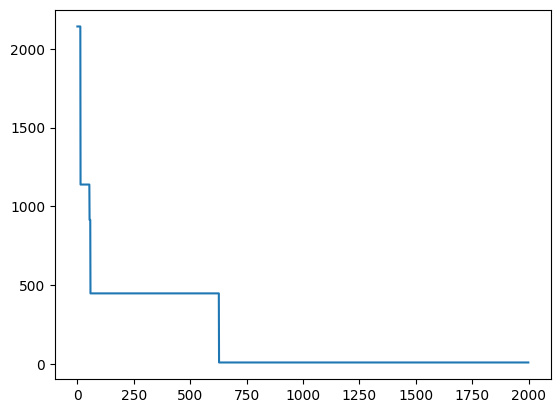

In [9]:
plt.plot(hist)
plt.show()

## Задача 2: Задача N ферзей

**Задание**:
Вам нужно разместить $N$ ферзей на шахматной доске размером $N\times N$ таким образом, чтобы они не атаковали друг друга.

Прежде всего, давайте решим задачу без генетических алгоритмов, используя полный перебор. Мы можем представить состояние доски списком $L$, где $i$-й номер в списке — это горизонтальное положение ферзя в $i$-й строке. Совершенно очевидно, что каждое решение будет иметь только одного ферзя в строке, и в каждой строке будет ферзь.

Наша цель — найти первое решение задачи, после чего мы прекратим поиск. Вы можете легко расширить эту функцию, чтобы сгенерировать все возможные позиции для ферзей.

In [10]:
N = 8

def checkbeats(i_new,j_new,l):
    for i,j in enumerate(l,start=1):
        if j==j_new:
            return False
        else:
            if abs(j-j_new) == i_new-i:
                return False
    return True

def nqueens(l,N=8,disp=True):
    if len(l)==N:
        if disp: print(l)
        return True
    else:
        for j in range(1,N+1):
            if checkbeats(len(l)+1,j,l):
                l.append(j)
                if nqueens(l,N,disp): return True
                else: l.pop()
        return False

nqueens([],8)


[1, 5, 8, 6, 3, 7, 2, 4]


True

Теперь давайте посчитаем, сколько времени потребуется, чтобы решить задачу о 20 ферзях:

In [11]:
%timeit nqueens([],20,False)

1.33 s ± 13.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Теперь давайте решим ту же задачу с помощью генетического алгоритма. Это решение вдохновлено [этим постом в блоге](https://kushalvyas.github.io/gen_8Q.html).

Мы представим каждое решение тем же списком длины $N$, а в качестве функции `fit` мы возьмем количество ферзей, которые атакуют друг друга:

In [12]:
def fit(L):
    x=0
    for i1,j1 in enumerate(L,1):
        for i2,j2 in enumerate(L,1):
            if i2>i1:
                if j2==j1 or (abs(j2-j1)==i2-i1): x+=1
    return x

Поскольку вычисление функции приспособленности занимает много времени, давайте сохраним каждое решение в популяции вместе со значением функции приспособленности. Давайте сгенерируем начальную популяцию:

In [13]:
def generate_one(N):
    x = np.arange(1,N+1)
    np.random.shuffle(x)
    return (x,fit(x))

def generate(N,NP):
    return [generate_one(N) for _ in range(NP)]

generate(8,5)

[(array([7, 3, 5, 1, 4, 6, 2, 8]), 4),
 (array([5, 3, 6, 2, 1, 4, 7, 8]), 5),
 (array([6, 1, 7, 3, 2, 5, 4, 8]), 8),
 (array([7, 4, 3, 8, 1, 6, 5, 2]), 7),
 (array([5, 4, 2, 1, 7, 3, 6, 8]), 5)]

Теперь нам нужно определить функции мутации и кроссинговера. Кроссинговер объединит два гена, разбив их в некоторой случайной точке и соединив две части из разных генов вместе.

In [18]:
def mutate(G):
    x=random.randint(0,len(G)-1)
    G[x]=random.randint(1,len(G))
    return G

def xover(G1,G2):
    x=random.randint(0,len(G1))
    return np.concatenate((G1[:x],G2[x:]))

xover([1,2,3,4],[5,6,7,8])

array([1, 6, 7, 8])

Мы улучшим процесс отбора генов, выбрав больше генов с лучшей функцией приспособленности. Вероятность отбора гена будет зависеть от функции приспособленности:

In [20]:
def choose_rand(P):
    N = len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p = np.random.choice(len(P),2,False,p=w)
    return p[0],p[1]

def choose(P):
    def ch(w):
        p=[]
        while p==[]:
            r = random.random()
            p = [i for i,x in enumerate(P) if x[1]>=r]
        return random.choice(p)
    N = len(P[0][0])
    mf = N*(N-1)//2 # max fitness fn
    z = [mf-x[1] for x in P]
    tf = sum(z) # total fitness
    w = [x/tf for x in z]
    p1=p2=0
    while p1==p2:
        p1 = ch(w)
        p2 = ch(w)
    return p1,p2

Теперь давайте определим основной эволюционный цикл. Мы сделаем логику немного отличной от предыдущего примера, чтобы показать, что можно проявить креативность. Мы будем циклить, пока не получим идеальное решение (функция приспособленности = 0), и на каждом шаге мы будем брать текущее поколение и производить новое поколение того же размера. Это делается с помощью функции `nxgeneration`, используя следующие шаги:

1. Отбрасываем самые непригодные решения — есть функция `discard_unfit`, которая это делает
1. Добавляем еще несколько случайных решений в поколение
1. Заселяем новое поколение размером `gen_size`, используя следующие шаги для каждого нового гена:
- выбираем два случайных гена с вероятностью, пропорциональной функции приспособленности
- вычисляем кроссовер
- применяем мутацию с вероятностью `mutation_prob`

In [21]:
mutation_prob = 0.1

def discard_unfit(P):
    P.sort(key=lambda x:x[1])
    return P[:len(P)//3]

def nxgeneration(P):
    gen_size=len(P)
    P = discard_unfit(P)
    P.extend(generate(len(P[0][0]),3))
    new_gen = []
    for _ in range(gen_size):
        p1,p2 = choose_rand(P)
        n = xover(P[p1][0],P[p2][0])
        if random.random()<mutation_prob:
            n=mutate(n)
        nf = fit(n)
        new_gen.append((n,nf))
        '''
        if (nf<=P[p1][1]) or (nf<=P[p2][1]):
            new_gen.append((n,nf))
        elif (P[p1][1]<P[p2][1]):
            new_gen.append(P[p1])
        else:
            new_gen.append(P[p2])
        '''
    return new_gen

def genetic(N,pop_size=100):
    P = generate(N,pop_size)
    mf = min([x[1] for x in P])
    n=0
    while mf>0:
        #print("Generation {0}, fit={1}".format(n,mf))
        n+=1
        mf = min([x[1] for x in P])
        P = nxgeneration(P)
    mi = np.argmin([x[1] for x in P])
    return P[mi]

genetic(8)

(array([3, 8, 4, 7, 1, 6, 2, 5]), 0)

Интересно, что в большинстве случаев мы можем получить решение довольно быстро, но в некоторых редких случаях оптимизация достигает локального минимума, и процесс застревает надолго. Важно учитывать это при измерении среднего времени: хотя в большинстве случаев генетический алгоритм будет быстрее полного поиска, в некоторых случаях он может занять больше времени. Чтобы преодолеть эту проблему, часто имеет смысл ограничить количество рассматриваемых поколений, и если мы не можем найти решение, мы можем начать с нуля.

In [23]:
%timeit genetic(10)

The slowest run took 331.64 times longer than the fastest. This could mean that an intermediate result is being cached.
5.62 s ± 7.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [30]:
%time genetic(10)

CPU times: user 5.75 s, sys: 3.32 ms, total: 5.75 s
Wall time: 5.77 s


(array([ 4,  8,  3,  9,  6, 10,  1,  7,  5,  2]), 0)

## Задание для самостоятельной работы

Представьте, что вы работаете в логистической компании, которая занимается доставкой товаров в различные города. У вас есть коммивояжер, который должен посетить несколько городов, чтобы доставить товары, и вернуться обратно в исходный город. Задача заключается в том, чтобы определить оптимальный маршрут, который минимизирует общую дистанцию, пройденную коммивояжером.

https://ru.wikipedia.org/wiki/Задача_коммивояжёра

### Формулировка задачи

**Входные данные:**

Предположим, у нас есть набор городов:

$C = {c_1, c_2, ..., c_N}$, где $N$ — количество городов.


Также есть матрица расстояний $D$, где $D[i][j]$ — расстояние между городами $c_i$ и $c_j$.

$$
D =
\begin{bmatrix}
D[1][1] & D[1][2] & \dots & D[1][N] \\
D[2][1] & D[2][2] & \dots & D[2][N] \\
\vdots  & \vdots  & \ddots & \vdots  \\
D[N][1] & D[N][2] & \dots & D[N][N] \\
\end{bmatrix}
$$

Основные условия:
1. $D[i][i]$ = 0 (расстояние от города до самого себя).
2. $D[i][j]$ = $D[j][i]$ (симметричность расстояний между городами).

Расстояние может быть измерено в километрах, милях или любой другой единице измерения.

**Цель:**

Найти такой маршрут, который:

1. Посетит каждый город ровно один раз.
2. Вернется в исходный город.
3. Минимизирует общую длину маршрута.

**Выходные данные:**

Оптимальный маршрут (перестановка городов) и его длина.

### Примеры

**Пример 1:**

Города: $$A, B, C, D$$

|   | A  | B  | C  | D  |
|---|----|----|----|----|
| A |  0 | 10 | 15 | 20 |
| B | 10 |  0 | 35 | 25 |
| C | 15 | 35 |  0 | 30 |
| D | 20 | 25 | 30 |  0 |

**Оптимальный маршрут:** $$A → B → D → C → A$$

**Длина маршрута:** $$10 + 25 + 30 + 15 = 80$$

---

**Пример 2:**

Города: $$1, 2, 3$$

|   | A  | B  | C  |
|---|----|----|----|
| A |  0 |  5 | 10 |
| B |  5 |  0 |  2 |
| C | 10 |  2 |  0 |

**Оптимальный маршрут:** $$A → B → C → A$$

**Длина маршрута:** $$5 + 2 + 10 = 17$$


### Требования

**Ограничения**
Число городов $N$ может варьироваться от 3 до 50.

Расстояния между городами могут быть произвольными неотрицательными числами.

**Требования к решению**

Решение должно быть реализовано с использованием генетического алгоритма.

Учитывать возможность настройки параметров генетического алгоритма, таких как размер популяции, вероятность мутации и количество поколений.



### Этапы реализации решения
1. **Определение структуры данных:** Разработать структуру для хранения информации о городах и расстояниях (матрица расстояний).
2. **Генерация начальной популяции:** Сформировать набор случайных маршрутов (заполнить матрицу расстояний).
3. **Оценка приспособленности:** Реализовать функцию для вычисления длины маршрута.
4. **Операции кроссовера и мутации:** Создать функции для объединения двух маршрутов и внесения изменений в них.
5. **Эволюционный цикл:** Реализовать основной цикл, который обновляет популяцию и выбирает лучших индивидов.
6. **Вывод результатов:** Определить оптимальный маршрут и вывести его. Визуализировать процесс получения лучшего решения (см. график функции `fit`)